In [2]:
import os
import sys
import cv2
import numpy as np
import torch.utils.data
from PIL import Image
import torch
import torchvision
import pytorch3d as p3d
from pytorch3d.utils import cameras_from_opencv_projection
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PerspectiveCameras,
    AmbientLights,
    RasterizationSettings,
    MeshRendererWithFragments,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    PointsRasterizationSettings,
    PointsRasterizer,
    PointsRenderer,
    AlphaCompositor,
    NormWeightedCompositor,
    PointLights,
    MeshRenderer
)
import matplotlib.pyplot as plt
from pprint import pprint

In [3]:
def my_load_obj(filename):
    vertices = []
    faces_vertex, faces_uv = [], []
    uvs = []
    with open(filename, "r") as f:
        for s in f:
            l = s.strip()
            if len(l) == 0:
                continue
            parts = l.split(" ")
            if parts[0] == "vt":
                uvs.append([float(x) for x in parts[1:]])
            elif parts[0] == "v":
                vertices.append([float(x) for x in parts[1:]])
            elif parts[0] == "f":
                faces_vertex.append([int(x.split("/")[0]) for x in parts[1:]])
                faces_uv.append([int(x.split("/")[1]) for x in parts[1:]])
    # note that triangle ids are 0 indexed
    obj = {
        "verts": np.array(vertices, dtype=np.float32),
        "uvs": np.array(uvs, dtype=np.float32),
        "vert_ids": np.array(faces_vertex, dtype=np.int32) - 1,
        "uv_ids": np.array(faces_uv, dtype=np.int32) - 1,
    }
    return obj


def my_create_mesh(obj, tex, device):
    faces_uvs = obj['uv_ids']
    verts_uvs = obj['uvs']
    verts = obj['verts']
    faces = obj['vert_ids']
    
    faces_uvs = torch.LongTensor(faces_uvs).unsqueeze(0).to(device)
    verts_uvs = torch.FloatTensor(verts_uvs).unsqueeze(0).to(device)
    tex = torch.FloatTensor(tex).unsqueeze(0).to(device)
    
    # verts normalization
#     verts_mean = np.mean(verts, axis=0)
#     verts -= verts_mean
    
    verts = torch.FloatTensor(verts).unsqueeze(0).to(device)
    faces = torch.LongTensor(faces).unsqueeze(0).to(device)

    # Args of TexturesUV:
    # maps: (N, H, W, C)
    # faces_uvs: (N, F, 3) LongTensor, index into verts_uvs
    # verts_uvs: (N, V, 2) tensor, uv coordinates per vetex
    texture = TexturesUV(tex, faces_uvs, verts_uvs)
    mesh = Meshes(verts, faces, texture)
    return mesh


def normalize_depth(depth, zfar, znear=0):
    mask = (depth == -1)
    depth = 255 * depth / zfar
    depth[mask] = 255
    return depth


def denormalize_depth(depth, zfar, znear=0):
    mask = (depth == 255)
    # ?
    depth = depth.astype(np.float32) * zfar / 255.
    # depth = depth.astype(np.float32) / 255.
    depth[mask] = -1
    return depth

In [9]:
class Multiface():
    def __init__(self, resolution=1024):
        super(Multiface, self).__init__()
        self.resolution = resolution
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
            torch.cuda.set_device(device)
        else:
            raise Exception('gpu unavailable')
    
    def load_obj(self, obj_path=None, tex_path=None, bin_path=None):
        vertices = []
        faces_vertex, faces_uv = [], []
        uvs = []
        with open(obj_path, "r") as f:
            for s in f:
                l = s.strip()
                if len(l) == 0:
                    continue
                parts = l.split(" ")
                if parts[0] == "vt":
                    uvs.append([float(x) for x in parts[1:]])
                elif parts[0] == "v":
                    vertices.append([float(x) for x in parts[1:]])
                elif parts[0] == "f":
                    faces_vertex.append([int(x.split("/")[0]) for x in parts[1:]])
                    faces_uv.append([int(x.split("/")[1]) for x in parts[1:]])
        # note that triangle ids are 0 indexed
        obj = {
            "verts": np.array(vertices, dtype=np.float32),
            "uvs": np.array(uvs, dtype=np.float32),
            "vert_ids": np.array(faces_vertex, dtype=np.int32) - 1,
            "uv_ids": np.array(faces_uv, dtype=np.int32) - 1,
        }
        verts = np.fromfile(bin_path, dtype=np.float32).reshape((-1, 3))
        tex = cv2.imread(tex_path).astype(np.float32)[..., ::-1] / 255.
        tex = cv2.resize(tex, (self.resolution, self.resolution))
        return obj, verts, tex
        
    def create_mesh(self, obj=None, verts=None, tex=None):
        """
        Args:
            maps: (N, H, W, C)
            faces_uvs: (N, F, 3) LongTensor, index into verts_uvs
            verts_uvs: (N, V, 2) FloatTensor, uv coordinates of each vetex
            
        """
        device = self.device
        faces_uvs = obj['uv_ids']
        verts_uvs = obj['uvs']
        faces = obj['vert_ids']
    
        faces_uvs = torch.LongTensor(faces_uvs).unsqueeze(0).to(device)
        verts_uvs = torch.FloatTensor(verts_uvs).unsqueeze(0).to(device)
        tex = torch.FloatTensor(tex).unsqueeze(0).to(device)
        faces = torch.LongTensor(faces).unsqueeze(0).to(device)
        
        verts_mean = np.mean(verts, axis=0)
        verts -= verts_mean  
        verts = torch.FloatTensor(verts).unsqueeze(0).to(device)

        texture = TexturesUV(tex, faces_uvs, verts_uvs)
        mesh = Meshes(verts, faces, texture)
        return mesh
    
    def norm_depth(self, depth, zfar, znear=0, denorm=False):
        if not denorm:
            mask = (depth == -1)
            depth = 255 * depth / zfar
            depth[mask] = 255
        else:
            mask = (depth == 255)
            depth = depth.astype(np.float32) * zfar / 255.
            depth[mask] = -1
        return depth
    
    def render_image(self, mesh, dist=250, elev=0, azim=0, zfar=800, znear=1):
        device = self.device
        resolution = self.resolution
        
        R, T = look_at_view_transform(dist, elev, azim)
        cameras = FoVPerspectiveCameras(zfar=zfar, R=R, T=T, device=device)
        raster_settings = RasterizationSettings(
            image_size=resolution,
            blur_radius=0.0,
            faces_per_pixel=1
        )
        lights = AmbientLights(device=device)
        renderer = MeshRendererWithFragments(
            rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings).to(device),
            shader=SoftPhongShader(cameras=cameras, lights=lights).to(device)
        )

        color, fragments = renderer(mesh)
        depth = fragments.zbuf
        color = color[0, ..., :3].cpu().numpy() * 255
        color = color.astype(int)
        depth = depth[0, ..., :3].cpu().numpy()[:, :, 0]
        depth_norm = self.norm_depth(depth.copy(), zfar)
        return color, depth

Text(0.5, 1.0, 'Depth')

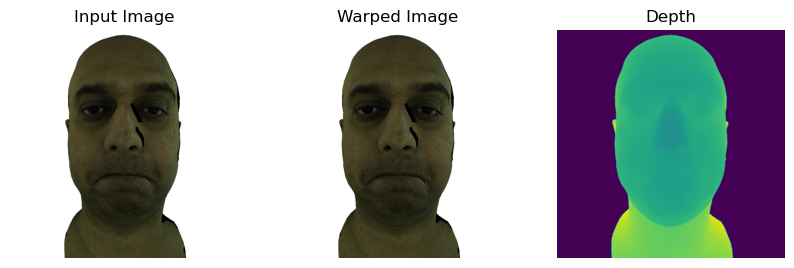

In [11]:
root_dir = '/home/tungi/datasets/multiface'
entity = 'm--20180227--0000--6795937--GHS'
express = 'E061_Lips_Puffed'
mesh_dir = os.path.join(root_dir, entity, 'tracked_mesh', express)
text_dir = os.path.join(root_dir, entity, 'unwrapped_uv_1024', express)
n_camera = '400023'
timing = '023389'
obj_path = os.path.join(mesh_dir, timing + '.obj')
tex_path = os.path.join(text_dir, n_camera, timing + '.png')
bin_path = os.path.join(mesh_dir, timing + '.bin')

m = Multiface()
obj, verts, tex = m.load_obj(obj_path=obj_path, tex_path=tex_path, bin_path=bin_path)
mesh = m.create_mesh(obj=obj, verts=verts, tex=tex)
color, depth = m.render_image(mesh, dist=250, elev=0, azim=0)

fig, axis = plt.subplots(1,3, figsize=(10,20))
axis[0].axis('off')
axis[1].axis('off')
axis[2].axis('off')

axis[0].imshow(color)
axis[0].set_title('Input Image')
axis[1].imshow(color)
axis[1].set_title('Warped Image')
axis[2].imshow(depth)
axis[2].set_title('Depth')

In [3]:
root_dir = '/home/tungi/datasets/multiface'
entity = 'm--20180227--0000--6795937--GHS'
express = 'E061_Lips_Puffed'
mesh_dir = os.path.join(root_dir, entity, 'tracked_mesh', express)
text_dir = os.path.join(root_dir, entity, 'unwrapped_uv_1024', express)
n_camera = '400023'
timing = '023389'

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    raise Exception('gpu unavailable')
    
obj_path = os.path.join(mesh_dir, timing + '.obj')
tex_path = os.path.join(text_dir, n_camera, timing + '.png')
# tex_path = '/home/tungi/datasets/multiface/m--20180227--0000--6795937--GHS/tex_mean.png'
bin_path = os.path.join(mesh_dir, timing + '.bin')

resol = 1024
obj = my_load_obj(obj_path)
tex = cv2.imread(tex_path).astype(np.float32)[..., ::-1] / 255.
tex = cv2.resize(tex, (resol, resol))

# mesh = my_create_mesh(obj, tex, device)
faces_uvs = obj['uv_ids']
verts_uvs = obj['uvs']
# verts = obj['verts']
faces = obj['vert_ids']
verts = np.fromfile(bin_path, dtype=np.float32).reshape((-1, 3))
    
faces_uvs = torch.LongTensor(faces_uvs).unsqueeze(0).to(device)
verts_uvs = torch.FloatTensor(verts_uvs).unsqueeze(0).to(device)
tex = torch.FloatTensor(tex).unsqueeze(0).to(device)
    
# verts normalization
verts_mean = np.mean(verts, axis=0)
verts -= verts_mean
    
verts = torch.FloatTensor(verts).unsqueeze(0).to(device)
faces = torch.LongTensor(faces).unsqueeze(0).to(device)

texture = TexturesUV(tex, faces_uvs, verts_uvs)
mesh = Meshes(verts, faces, texture)

NameError: name 'my_load_obj' is not defined

In [ ]:
# Visualize the vertices on the texture map (takes a few min to process)
# plt.figure(figsize=(7,7))
# texturesuv_image_matplotlib(mesh.textures, subsample=None)
# plt.axis("off");

In [89]:
# trans_path = os.path.join(root_dir, entity, 'tracked_mesh', express, timing + '_transform.txt')
# trans_mat = []
# with open(trans_path, "r") as f:
#     for l in f:
#         trans_mat.append([float(x) for x in l.split(' ')])
# trans_mat = np.array(trans_mat, dtype=np.float32)

In [87]:
KRT_path = os.path.join(root_dir, entity, 'KRT.txt')
KRT_dict =OrderedDict()
with open(trans_path, "r") as f:
    for l in f:

tensor([[3.8349e-01, 4.6382e-01, 1.0242e+03]])

In [93]:
RT_mat = [
    [0.97629625, 0.0029071984, 0.21641898, -276.7496],
    [0.10491906, 0.86821574, -0.48496747, 457.45486],
    [-0.18930826, 0.4961784, 0.84733075, 192.55482,]
]

RT_mat = np.array(RT_mat, dtype=np.float32)
R = torch.FloatTensor(RT_mat[:, :3]).unsqueeze(0)
T = torch.FloatTensor(RT_mat[:, 3]).unsqueeze(0)

tensor([[-276.7496,  457.4549,  192.5548]])

In [45]:
torch.tensor([resol, resol]).unsqueeze(0).size()

torch.Size([1, 2])

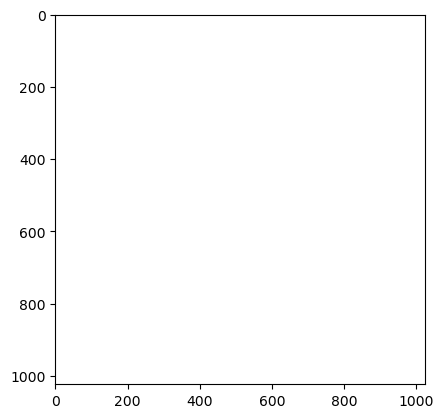

In [53]:
int_mat = [
    [5069.297, 0, 600.5907],
    [0, 5068.6997, 1016.2735],
    [0, 0, 1]
]
ext_mat = [
    [0.9956278, -0.0052650357, -0.0932603, 121.17298],
    [0.0041177114, 0.9999135, -0.012490546, -0.52072936],
    [0.093318, 0.012051917, 0.9955634, 34.179264]
]
int_mat = np.array(int_mat, dtype=np.float32)
ext_mat = np.array(ext_mat, dtype=np.float32)
R = torch.FloatTensor(ext_mat[:, :3]).unsqueeze(0)
T = torch.FloatTensor(ext_mat[:, 3]).unsqueeze(0)
# F = torch.FloatTensor([int_mat[(0, 1), (0, 1)].mean()]).unsqueeze(0)
F = torch.FloatTensor([1, 1]).unsqueeze(0)
# P = torch.FloatTensor(int_mat[(0, 1), (2, 2)]).unsqueeze(0)
P = torch.FloatTensor([0, 0]).unsqueeze(0)

camera = PerspectiveCameras(focal_length=F, principal_point=P, R=R, T=T, in_ndc=True, \
                            image_size=torch.tensor([resol, resol]).unsqueeze(0), device=device)
raster_settings = RasterizationSettings(
    image_size=resol,
    blur_radius=0.0,
    faces_per_pixel=1
)
lights = AmbientLights(device=device)

renderer = MeshRendererWithFragments(
    rasterizer=MeshRasterizer(cameras=camera, raster_settings=raster_settings).to(device),
    shader=SoftPhongShader(cameras=camera, lights=lights).to(device)
)

color, fragments = renderer(mesh)
depth = fragments.zbuf
color = color[0, ..., :3].cpu().numpy() * 255
color = color.astype(int)
depth = depth[0, ..., :3].cpu().numpy()[:, :, 0]
depth_norm = normalize_depth(depth.copy(), zfar)

plt.imshow(color)

In [56]:
# pytorch3d camera coordinate system:
# +Y up, +X left and +Z in

dist, elev, azim = (250, 0, 0)
znear, zfar = (1, 800)
R, T = look_at_view_transform(dist, elev, azim)

# zfar = 1024
# RT_mat = [
#     [0.97629625, 0.0029071984, 0.21641898, -276.7496],
#     [0.10491906, 0.86821574, -0.48496747, 457.45486],
#     [-0.18930826, 0.4961784, 0.84733075, 192.55482,]
# ]
# RT_mat = np.array(RT_mat, dtype=np.float32)
# R = torch.FloatTensor(RT_mat[:, :3]).unsqueeze(0)
# T = torch.FloatTensor(RT_mat[:, 3]).unsqueeze(0)

camera = FoVPerspectiveCameras(zfar=zfar, R=R, T=T, device=device)
raster_settings = RasterizationSettings(
    image_size=resol,
    blur_radius=0.0,
    faces_per_pixel=1
)
lights = AmbientLights(device=device)

renderer = MeshRendererWithFragments(
    rasterizer=MeshRasterizer(cameras=camera, raster_settings=raster_settings).to(device),
    shader=SoftPhongShader(cameras=camera, lights=lights).to(device)
)

color, fragments = renderer(mesh)
depth = fragments.zbuf
color = color[0, ..., :3].cpu().numpy() * 255
color = color.astype(int)
depth = depth[0, ..., :3].cpu().numpy()[:, :, 0]
depth_norm = normalize_depth(depth.copy(), zfar)

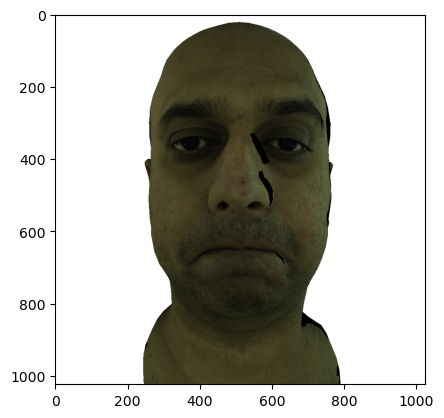

In [57]:
plt.imshow(color)

In [50]:
print(T)

tensor([[ -0.,  -0., 250.]])


In [58]:
mask = (depth >= 0)
y_mat = np.arange(resol)[:, None].repeat(resol, axis=1).astype(np.float32)
y_mat = - y_mat * 2 / (resol - 1) + 1
x_mat = y_mat.T
xy_depth = np.stack([x_mat, y_mat, depth], axis=2)
xy_depth = xy_depth[mask, :]
feats = color[mask, :]

xy_depth = torch.FloatTensor(xy_depth).unsqueeze(0).to(device)
feats = torch.FloatTensor(feats).unsqueeze(0).to(device)
# scaled_depth_input: if true, assume the input depth is in [0, 1]
# in_ndc: if true, assume xy is in NDC space even if the camera is defined in screen space
points = camera.unproject_points(xy_depth, scaled_depth_input=False, world_coordinates=True, in_ndc=True)
cloud = Pointclouds(points=points, features=feats)
cloud = cloud.to('cuda')

# novel view camera
dist_new, elev_new, azim_new = (250, 15, 15)
R_new, T_new = look_at_view_transform(dist_new, elev_new, azim_new)
camera_new = FoVPerspectiveCameras(zfar=zfar, R=R_new, T=T_new, device=device)

# point cloud renderer
raster_settings = PointsRasterizationSettings(
    image_size=resol,
    radius=0.003,
    points_per_pixel=10
)
rasterizer = PointsRasterizer(cameras=camera_new, raster_settings=raster_settings)
compositor = NormWeightedCompositor(background_color=(255, 255, 255))
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=compositor
).to(device)

# render novel view image
color_new = renderer(cloud)
color_new = color_new[0, ..., :3].cpu().numpy()
color_new = color_new.astype(int)

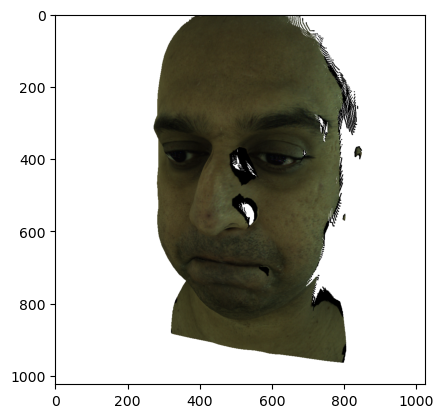

In [59]:
plt.imshow(color_new)

In [27]:
# v: [x, y, z]; vt: [u, v]; f: [v1/vt1, v2/vt2, v3/vt3]
with open(obj_path, "r") as f:
    for s in f:
        l = s.strip()
        print(l)

v -71.6363067627 29.2667560577 1078.89489746
v -45.418182373 70.5602035522 1006.07244873
v -17.1318340302 55.2790374756 977.943481445
v -42.3177261353 -8.67803287506 990.77557373
v -30.1976604462 -1.94897317886 983.864685059
v -38.969165802 -11.6772623062 990.629516602
v -26.438035965 -4.88945865631 984.625427246
v -21.0797519684 -39.3145561218 994.320861816
v -24.4901218414 -37.733253479 993.39630127
v -32.9638252258 -35.979839325 993.278137207
v -36.0409660339 -36.1420898438 994.574462891
v -40.7780685425 -37.5198249817 997.40222168
v -42.9423332214 -40.9311752319 996.00390625
v -38.2228393555 -43.0066833496 992.20098877
v -35.5795402527 -43.7897033691 990.81072998
v -30.3658905029 -45.2391815186 989.68560791
v -27.9463043213 -45.3743553162 989.785827637
v -25.5983562469 -45.3903121948 990.837341309
v -14.8324766159 -41.321182251 998.128417969
v -5.33792352676 29.9861812592 967.987792969
v -16.123298645 31.5154800415 976.595825195
v -22.574382782 35.9540023804 982.343566895
v -27.396